In [37]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import gensim
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('movie.csv')
data

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [3]:
def put_sentiment(x):
    if x==0:
        return 'Negative'
    if x==1:
        return 'Positive'

In [4]:
data['Sentiment'] = data['label'].apply(put_sentiment)
data

,text,label,Sentiment
0,I grew up (b. 1965) watching and loving the Th...,0,Negative
1,"When I put this movie in my DVD player, and sa...",0,Negative
2,Why do people who do not know what a particula...,0,Negative
3,Even though I have great interest in Biblical ...,0,Negative
4,Im a die hard Dads Army fan and nothing will e...,1,Positive
...,...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1,Positive
39996,This movie is an incredible piece of work. It ...,1,Positive
39997,My wife and I watched this movie because we pl...,0,Negative
39998,"When I first watched Flatliners, I was amazed....",1,Positive


**Exploratory data analysis**

In [11]:
data.groupby('Sentiment').nunique()

,text,label
Sentiment,,
Negative,19815,1
Positive,19908,1


This implies that we have a balanced distribution of sentiments across the Imdb reviews available in the dataset

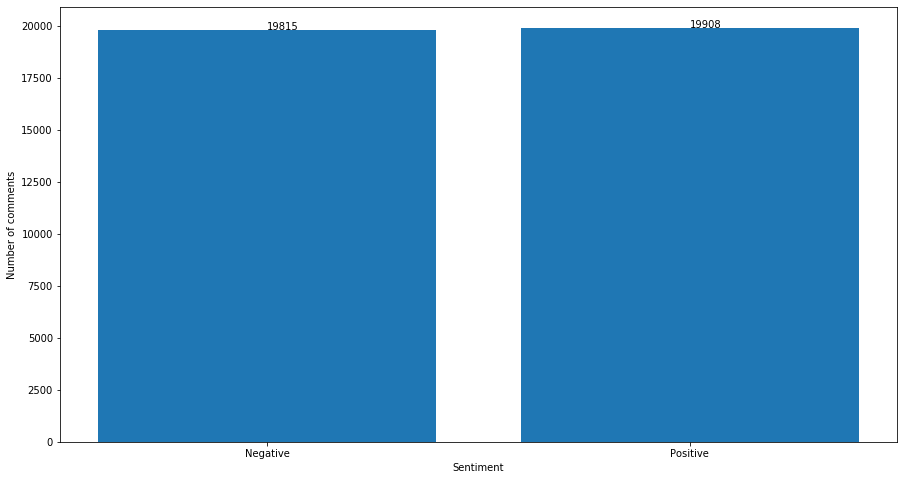

In [14]:
lis1a = ["Negative", "Positive"]
lis2a = [19815, 19908]

x = lis1a
y = lis2a

f1 = plt.figure()
f1.set_figwidth(15)
f1.set_figheight(8)
  
plt.xlabel('Sentiment')
plt.ylabel('Number of comments')
for a,b in zip(lis1a, lis2a): 
    plt.text(a, b, str(round(b,3)))

plt.bar(x, y)
plt.show()

In [17]:
#Let's check with the text column to understand if there exists any null entries
sum(data['text'].isna())

0

In [18]:
df = data.copy()
df.head()

,text,label,Sentiment
0,I grew up (b. 1965) watching and loving the Th...,0,Negative
1,"When I put this movie in my DVD player, and sa...",0,Negative
2,Why do people who do not know what a particula...,0,Negative
3,Even though I have great interest in Biblical ...,0,Negative
4,Im a die hard Dads Army fan and nothing will e...,1,Positive


In [19]:
def preprocess_sentence(x):
    x = re.sub('[^A-Za-z]+', ' ', x)
    x = re.sub(r' \w{1} |^\w{1} | \w{1}$', ' ', x).strip()
    x = x.lower()
    return x

In [20]:
df['preprocessed_text'] = df['text'].apply(preprocess_sentence)
df.head()

,text,label,Sentiment,preprocessed_text
0,I grew up (b. 1965) watching and loving the Th...,0,Negative,grew up watching and loving the thunderbirds a...
1,"When I put this movie in my DVD player, and sa...",0,Negative,when put this movie in my dvd player and sat d...
2,Why do people who do not know what a particula...,0,Negative,why do people who do not know what particular ...
3,Even though I have great interest in Biblical ...,0,Negative,even though have great interest in biblical mo...
4,Im a die hard Dads Army fan and nothing will e...,1,Positive,im die hard dads army fan and nothing will eve...


In [27]:
data = np.array(df['preprocessed_text'])
data[:5]

array(['grew up watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from became an art form took my children to see the movie hoping they would get glimpse of what loved as child how bitterly disappointing the only high point was the snappy theme tune not that it could compare with the original score of the thunderbirds thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created jonatha frakes should hand in his directors chair his version was completely hopeless waste of film utter rubbish cgi remake may be acceptable but replacing marionettes with homo sapiens subsp sapiens was huge error of judgment',
       'when put this movie in my dvd player and sat down with coke and some chips had some expectations was hoping that this movie would contain some of the stron

In [32]:
labels = tf.keras.utils.to_categorical(np.array(df['label']), 2, dtype="float32")

In [35]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [36]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   11  616    3]
 [ 801 1039    6 ...   37   19  233]
 [   0    0    0 ...    1   17 2249]
 ...
 [   0    0    0 ... 4679  766   30]
 [   0    0    0 ...   65    6    6]
 [   0    0    0 ...  331   56  916]]


In [38]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

30000 10000 30000 10000


In [41]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(6,dropout=0.25, return_sequences=True))
model1.add(Dropout(0.4))
model1.add(layers.LSTM(2,dropout=0.25))
model1.add(Dropout(0.4))
model1.add(layers.Dense(2,activation='softmax'))

In [42]:
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("Imdb_senti_best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7366
Epoch 1: val_accuracy improved from -inf to 0.85610, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 129s 131ms/step - loss: 0.5348 - accuracy: 0.7366 - val_loss: 0.3866 - val_accuracy: 0.8561
Epoch 2/20
938/938 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8116
Epoch 2: val_accuracy did not improve from 0.85610
938/938 [==============================] - 121s 129ms/step - loss: 0.4037 - accuracy: 0.8116 - val_loss: 0.3811 - val_accuracy: 0.8425
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8278
Epoch 3: val_accuracy improved from 0.85610 to 0.87750, saving model to Imdb_senti_best_model1.hdf5
938/938 [==============================] - 122s 130ms/step - loss: 0.3650 - accuracy: 0.8278 - val_loss: 0.3015 - val_accuracy: 0.8775
Epoch 4/20
938/938 [==============================] - ETA: 

In [43]:
best_model = keras.models.load_model("Imdb_senti_best_model1.hdf5")

In [44]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

313/313 - 9s - loss: 0.3048 - accuracy: 0.8840 - 9s/epoch - 29ms/step
Model accuracy:  0.8840000033378601


In [48]:
predictor = best_model.predict(X_test)

313/313 [==============================] - 7s 21ms/step


In [51]:
sentiment = {1:'Positive', 0:'Negative'}

In [52]:
sequence = tokenizer.texts_to_sequences(['I watched that comedy drama the other day which was so boring and tiring'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 42ms/step


'Negative'

In [53]:
sequence = tokenizer.texts_to_sequences(['The movie which starred Alekhya Nayaki as the queen of Pappula clan with a modified face resembling a dog was so damn awesome and a sureshot blockbuster'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 41ms/step


'Positive'